# Pre Processing

In [60]:

import pandas as pd
!pip install dmba
!pip install pykan


In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [62]:
df = pd.read_csv('DataCoSupplyChainDataset.csv', header=0, encoding='unicode_escape')

In [63]:




# Initial inspection
print(df.shape)
print(df.info())
print(df.isnull().sum())

# Create full customer name
df['Cust_Full_Name'] = df['Customer Fname'].astype(str) + df['Customer Lname'].astype(str)

# Data Cleaning
data = df.copy()
data.drop(['Customer Email', 'Product Status', 'Customer Password', 'Customer Street', 'Customer Fname',
           'Customer Lname', 'Latitude', 'Longitude', 'Product Description', 'Product Image', 'Order Zipcode',
           'shipping date (DateOrders)', 'Type'], axis=1, inplace=True)

# Drop rows with missing values in 'Product Price' and 'Shipping Mode'
data = data.dropna(subset=['Product Price', 'Shipping Mode'])

# Extract date features from 'order date (DateOrders)'
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'], errors='coerce')
data['order_yr'] = data['order date (DateOrders)'].dt.year
data['order_month'] = data['order date (DateOrders)'].dt.month
data['order_day'] = data['order date (DateOrders)'].dt.weekday
data['order_hour'] = data['order date (DateOrders)'].dt.hour

# Drop the original 'order date (DateOrders)' column
data.drop(['order date (DateOrders)'], axis=1, inplace=True)

# Create a fraud flag based on 'Order Status'
data['flagged'] = np.where(data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)

# Drop rows where 'Customer Zipcode' is NaN
data = data.dropna(subset=['Customer Zipcode'])

# Identify categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols)

# Label encoding categorical variables
le = preprocessing.LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Select features and target variable
X = data.drop('flagged', axis=1)
y = data['flagged']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Method 1: Mutual Information
mi_scores = mutual_info_classif(X_scaled, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

### Method 2: Random Forest Feature Importance
rf_model = RandomForestClassifier()
rf_model.fit(X_scaled, y)
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

### Method 3: Recursive Feature Elimination (RFE)
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X_scaled, y)
rfe_support = pd.Series(fit.support_, index=X.columns)
rfe_ranking = pd.Series(fit.ranking_, index=X.columns).sort_values()

# Combine Results
combined_rankings = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores.rank(ascending=False),
    'Random Forest Importance': rf_importances.rank(ascending=False),
    'RFE Ranking': rfe_ranking.rank()
})

# Ensure all ranking columns are numeric
for col in ['Mutual Information', 'Random Forest Importance', 'RFE Ranking']:
    combined_rankings[col] = pd.to_numeric(combined_rankings[col])

combined_rankings['Average Ranking'] = combined_rankings[['Mutual Information', 'Random Forest Importance', 'RFE Ranking']].mean(axis=1)
combined_rankings = combined_rankings.sort_values('Average Ranking')

# Select top features
top_features = combined_rankings.head(10)['Feature']

# Create a dataframe with selected features
important_features_df = data[top_features]
important_features_df['flagged'] = y


(180519, 53)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname   

C:\Users\chris\AppData\Local\Temp\ipykernel_26996\1600081856.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  important_features_df['flagged'] = y


In [64]:

# Display the dataframe
print(important_features_df.head())

# Save the dataframe to a CSV file if needed
#important_features_df.to_csv('/mnt/data/important_features_df.csv', index=False)


   Order State  Customer State  Department Name  Cust_Full_Name  Customer Id  \
0          475              34                4            1876        20755   
1          841              34                4            5377        19492   
2          841               3                4            4428        19491   
3          835               3                4           12927        19490   
4          835              34                4           10637        19489   

   Order City  Customer Segment  Order Id  Sales per customer  Category Id  \
0         331                 0     77202          314.640015           73   
1         391                 0     75939          311.359985           73   
2         391                 0     75938          309.720001           73   
3        3226                 2     75937          304.809998           73   
4        3226                 1     75936          298.250000           73   

   flagged  
0        0  
1        0  
2        0 

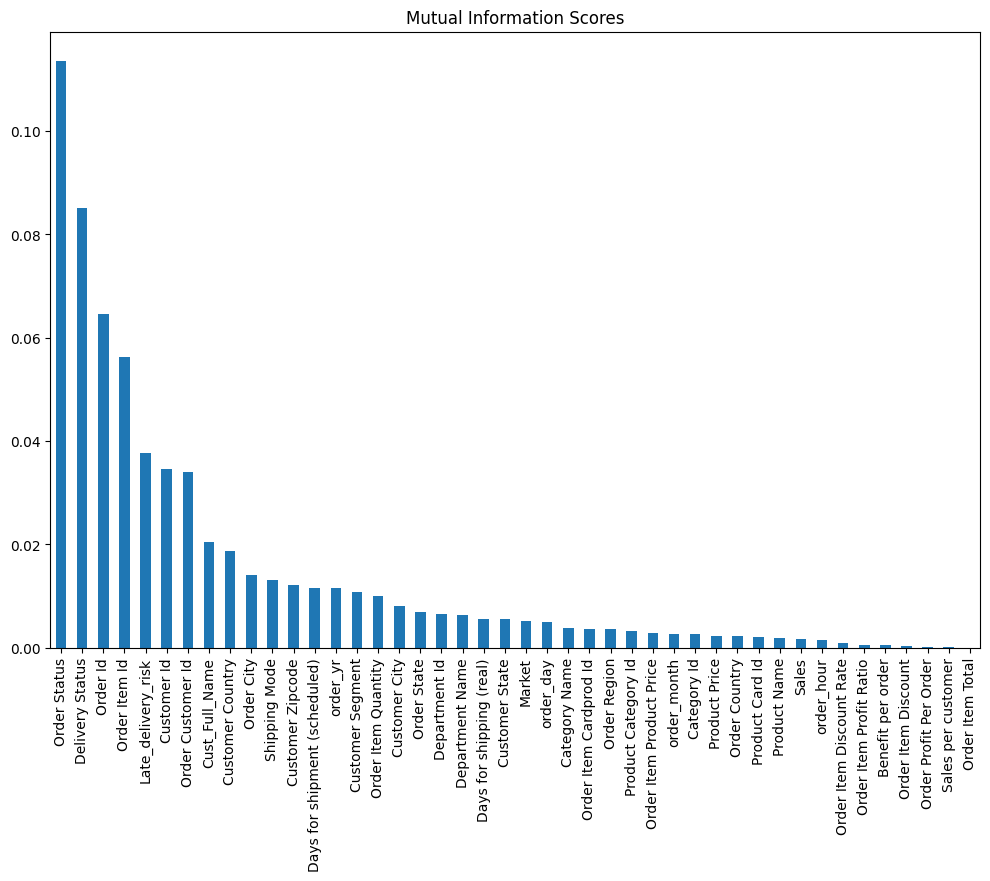

In [65]:

# Plot mutual information scores
plt.figure(figsize=(12, 8))
mi_scores.plot(kind='bar')
plt.title('Mutual Information Scores')
plt.show()


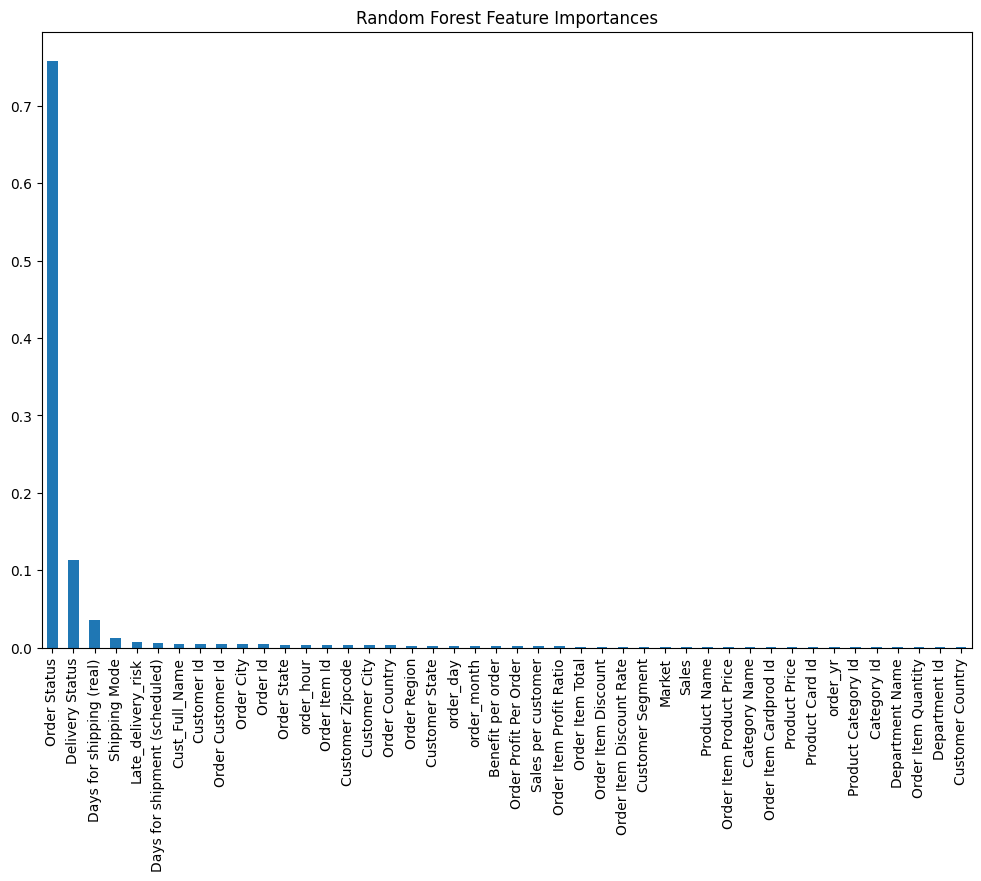

In [66]:

# Plot Random Forest feature importances
plt.figure(figsize=(12, 8))
rf_importances.plot(kind='bar')
plt.title('Random Forest Feature Importances')
plt.show()


In [67]:

# Display combined rankings
combined_rankings

,Feature,Mutual Information,Random Forest Importance,RFE Ranking,Average Ranking
Order Status,Order State,1.0,1.0,5.5,2.500000
Delivery Status,Customer State,2.0,2.0,5.5,3.166667
Late_delivery_risk,Department Name,5.0,5.0,5.5,5.166667
Shipping Mode,Cust_Full_Name,11.0,4.0,5.5,6.833333
Days for shipment (scheduled),Customer Id,13.0,6.0,5.5,8.166667
Order City,Order City,10.0,10.0,5.5,8.500000
Days for shipping (real),Customer Segment,21.0,3.0,5.5,9.833333
Order Id,Order Id,3.0,11.0,20.0,11.333333
Cust_Full_Name,Sales per customer,8.0,7.0,22.0,12.333333
Customer Id,Category Id,6.0,8.0,27.0,13.666667


In [68]:
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import ADASYN

# Assuming 'data' is your cleaned DataFrame

# #Define the selected features and target variable
# #selected_features = ['Order State', 'Customer State', 'Department Name', 'Category Name', 'Cust_Full_Name',
#                      'Sales per customer', 'Order City', 'Order Customer Id', 'Order Item Id', 'Customer Segment']


selected_features = ['Order State', 'Customer State', 'Department Name', 'Category Name', 'Customer Id', 'Order City']


# Ensure the selected features and the target variable ('flagged') are in the DataFrame
data = data[selected_features + ['flagged']]


# Take a random sample of the data to reduce size
data_sampled = data.sample(n=10000, random_state=42)  # Adjust the sample size as needed


In [69]:
data_sampled.isnull().sum()

Order State        0
Customer State     0
Department Name    0
Category Name      0
Customer Id        0
Order City         0
flagged            0
dtype: int64

In [70]:
data_sampled

,Order State,Customer State,Department Name,Category Name,Customer Id,Order City,flagged
180209,1039,30,3,18,10198,233,0
113870,470,34,3,30,3235,3194,0
173061,230,34,6,38,8755,705,0
42805,161,3,0,12,12032,1741,0
54460,292,9,3,46,2089,803,0
...,...,...,...,...,...,...,...
68510,986,34,5,10,4380,966,0
43235,655,29,6,47,7365,2040,0
53062,462,34,3,46,6720,454,0
11777,341,34,6,47,9296,1059,0


In [71]:
import pandas as pd
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
import torch


# Separate features and target variable
X = data_sampled.drop('flagged', axis=1)
y = data_sampled['flagged']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Balance the training dataset using ADASYN
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

# Display the class distribution after resampling
print(y_train_res.value_counts())

# Convert the resampled training data to PyTorch tensors
dataset = {}
dataset['train_input'] = torch.from_numpy(X_train_res.values.astype('float32'))
dataset['test_input'] = torch.from_numpy(X_test.values.astype('float32'))

# Convert the resampled training labels to PyTorch tensors
dataset['train_label'] = torch.from_numpy(y_train_res.values.astype('int64'))
dataset['test_label'] = torch.from_numpy(y_test.values.astype('int64'))

# Verify the shapes
print(dataset['train_input'].shape)
print(dataset['train_label'].shape)


flagged
0    7822
1    7819
Name: count, dtype: int64
torch.Size([15641, 6])
torch.Size([15641])


In [75]:

# Initialize the KAN model with the correct input dimensions
from kan import KAN

input_dim = dataset['train_input'].shape[1]  # This should be 5 based on your input data
output_dim = 1  # Assuming a single output node for regression-like approach

# Adjust the KAN model initialization
model = KAN(width=[input_dim, output_dim], grid=3, k=3)


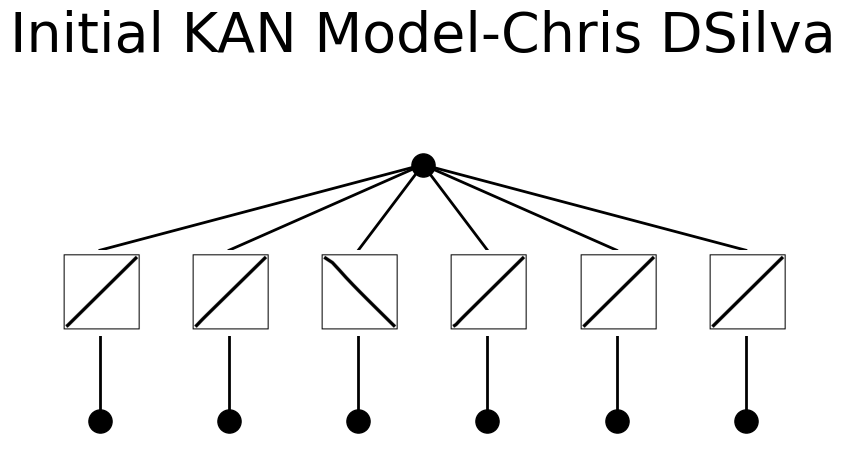

In [76]:

# Perform a forward pass to initialize and plot the model
model(dataset['train_input'])  # Perform a forward pass to initialize
model.plot(beta=100, scale=1, title='Initial KAN Model-Chris DSilva')  # Adjust beta and scale as needed


In [77]:

# Define training and testing accuracy functions
def train_acc():
    logits = model(dataset['train_input'])[:, 0]  # Get raw logits from the model
    pred = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
    rounded_pred = torch.round(pred)  # Round probabilities to get binary predictions
    acc = (rounded_pred == dataset['train_label']).float().mean()
    print("Train logits sample:", logits[:10])  # Print sample logits to inspect
    print("Train predictions sample:", pred[:10])  # Print probabilities to check
    return acc

def test_acc():
    logits = model(dataset['test_input'])[:, 0]
    pred = torch.sigmoid(logits)
    rounded_pred = torch.round(pred)
    acc = (rounded_pred == dataset['test_label']).float().mean()
    print("Test logits sample:", logits[:10])  # Print sample logits to inspect
    print("Test predictions sample:", pred[:10])  # Print probabilities to check
    return acc

# Train the model
image_folder = 'kan_without_pca'

results = model.train(
    dataset, opt="LBFGS", steps=50, metrics=(train_acc, test_acc), beta=50, img_folder=image_folder, save_fig=True
)

print(f'Train Accuracy: {results["train_acc"][-1]}')
print(f'Test Accuracy: {results["test_acc"][-1]}')


train loss: 6.74e-01 | test loss: 6.65e-01 | reg: 2.30e+00 :   0%|           | 0/50 [00:36<?, ?it/s]

Train logits sample: tensor([ 0.2423,  0.2495, -0.4499,  0.4333,  1.0550,  0.1420,  0.1439,  0.0083,
        -0.3536, -0.1090], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.5603, 0.5620, 0.3894, 0.6067, 0.7417, 0.5354, 0.5359, 0.5021, 0.4125,
        0.4728], grad_fn=<SliceBackward0>)
Test logits sample: tensor([1.1018, 0.5326, 0.1724, 0.6858, 0.0524, 0.5941, 0.7523, 1.1856, 0.7852,
        0.4575], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.7506, 0.6301, 0.5430, 0.6650, 0.5131, 0.6443, 0.6797, 0.7660, 0.6868,
        0.6124], grad_fn=<SliceBackward0>)


train loss: 6.21e-01 | test loss: 6.00e-01 | reg: 2.04e+00 :   2%|   | 1/50 [01:15<30:56, 37.88s/it]

Train logits sample: tensor([ 4.0504e-01,  5.3681e-01,  4.0933e-05,  1.5679e-01,  1.0064e+00,
         3.8130e-01,  2.4297e-01,  1.6573e-01, -4.4180e-01, -1.0818e-01],
       grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.5999, 0.6311, 0.5000, 0.5391, 0.7323, 0.5942, 0.5604, 0.5413, 0.3913,
        0.4730], grad_fn=<SliceBackward0>)
Test logits sample: tensor([1.0990, 0.5460, 0.0978, 0.7126, 0.4012, 0.0147, 0.5696, 0.8741, 0.6437,
        0.6103], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.7501, 0.6332, 0.5244, 0.6710, 0.5990, 0.5037, 0.6387, 0.7056, 0.6556,
        0.6480], grad_fn=<SliceBackward0>)


train loss: 5.13e-01 | test loss: 5.04e-01 | reg: 3.26e+00 :   4%|   | 2/50 [02:00<30:50, 38.56s/it]

Train logits sample: tensor([0.4215, 0.4989, 0.4796, 0.5200, 0.7157, 0.4653, 0.6281, 0.6226, 0.2169,
        0.3603], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6038, 0.6222, 0.6177, 0.6271, 0.6717, 0.6143, 0.6521, 0.6508, 0.5540,
        0.5891], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.5335, 0.5080, 0.3170, 0.5926, 0.5009, 0.4788, 0.5650, 0.3598, 0.3468,
        0.5541], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6303, 0.6243, 0.5786, 0.6440, 0.6227, 0.6175, 0.6376, 0.5890, 0.5858,
        0.6351], grad_fn=<SliceBackward0>)


train loss: 5.12e-01 | test loss: 5.02e-01 | reg: 3.32e+00 :   6%|▏  | 3/50 [02:21<32:24, 41.37s/it]

Train logits sample: tensor([0.4073, 0.4830, 0.4495, 0.5351, 0.7175, 0.4443, 0.6142, 0.5826, 0.2235,
        0.3574], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6004, 0.6185, 0.6105, 0.6307, 0.6721, 0.6093, 0.6489, 0.6417, 0.5556,
        0.5884], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.5350, 0.4996, 0.3357, 0.5670, 0.4660, 0.5116, 0.5853, 0.3999, 0.3676,
        0.5395], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6306, 0.6224, 0.5832, 0.6381, 0.6144, 0.6252, 0.6423, 0.5987, 0.5909,
        0.6317], grad_fn=<SliceBackward0>)


train loss: 5.12e-01 | test loss: 5.02e-01 | reg: 3.32e+00 :   8%|▏  | 4/50 [02:34<27:03, 35.30s/it]

Train logits sample: tensor([0.4073, 0.4829, 0.4493, 0.5351, 0.7174, 0.4443, 0.6141, 0.5826, 0.2235,
        0.3574], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6004, 0.6184, 0.6105, 0.6307, 0.6720, 0.6093, 0.6489, 0.6417, 0.5557,
        0.5884], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.5348, 0.4996, 0.3357, 0.5670, 0.4659, 0.5118, 0.5852, 0.3999, 0.3675,
        0.5394], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6306, 0.6224, 0.5831, 0.6381, 0.6144, 0.6252, 0.6423, 0.5987, 0.5909,
        0.6317], grad_fn=<SliceBackward0>)


train loss: 5.12e-01 | test loss: 4.99e-01 | reg: 3.30e+00 :  10%|▎  | 5/50 [03:41<19:16, 25.70s/it]

Train logits sample: tensor([0.3980, 0.4705, 0.4559, 0.5189, 0.7068, 0.4485, 0.5986, 0.5637, 0.2280,
        0.3697], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.5982, 0.6155, 0.6120, 0.6269, 0.6697, 0.6103, 0.6453, 0.6373, 0.5568,
        0.5914], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.5273, 0.4988, 0.3444, 0.5431, 0.4646, 0.5074, 0.6001, 0.3950, 0.3770,
        0.5338], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6289, 0.6222, 0.5853, 0.6325, 0.6141, 0.6242, 0.6457, 0.5975, 0.5932,
        0.6304], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.97e-01 | reg: 2.94e+00 :  12%|▎  | 6/50 [04:37<29:17, 39.95s/it]

Train logits sample: tensor([0.4978, 0.4841, 0.5087, 0.5180, 0.5024, 0.5275, 0.4910, 0.4980, 0.4859,
        0.4675], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6219, 0.6187, 0.6245, 0.6267, 0.6230, 0.6289, 0.6204, 0.6220, 0.6191,
        0.6148], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4871, 0.4972, 0.4911, 0.5090, 0.5293, 0.4789, 0.5325, 0.4744, 0.4877,
        0.5169], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6194, 0.6218, 0.6204, 0.6246, 0.6293, 0.6175, 0.6301, 0.6164, 0.6196,
        0.6264], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  14%|▍  | 7/50 [05:19<32:17, 45.06s/it]

Train logits sample: tensor([0.5000, 0.4878, 0.5090, 0.5192, 0.5029, 0.5268, 0.4916, 0.4951, 0.4851,
        0.4634], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6225, 0.6196, 0.6246, 0.6270, 0.6231, 0.6287, 0.6205, 0.6213, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4880, 0.4960, 0.4912, 0.5079, 0.5280, 0.4754, 0.5293, 0.4781, 0.4868,
        0.5171], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6215, 0.6204, 0.6243, 0.6290, 0.6167, 0.6293, 0.6173, 0.6194,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  16%|▍  | 8/50 [05:29<30:52, 44.12s/it]

Train logits sample: tensor([0.4999, 0.4878, 0.5090, 0.5192, 0.5031, 0.5267, 0.4918, 0.4953, 0.4849,
        0.4635], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6224, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6214, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4960, 0.4912, 0.5081, 0.5281, 0.4755, 0.5294, 0.4780, 0.4868,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6215, 0.6204, 0.6244, 0.6290, 0.6167, 0.6293, 0.6173, 0.6194,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  18%|▌  | 9/50 [05:35<22:54, 33.53s/it]

Train logits sample: tensor([0.4999, 0.4878, 0.5090, 0.5192, 0.5031, 0.5267, 0.4918, 0.4953, 0.4849,
        0.4635], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6224, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6213, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4960, 0.4912, 0.5081, 0.5281, 0.4755, 0.5294, 0.4780, 0.4868,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6215, 0.6204, 0.6244, 0.6290, 0.6167, 0.6293, 0.6173, 0.6194,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  20%|▍ | 10/50 [05:42<16:51, 25.29s/it]

Train logits sample: tensor([0.4999, 0.4878, 0.5090, 0.5192, 0.5031, 0.5267, 0.4918, 0.4953, 0.4849,
        0.4635], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6224, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6214, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4960, 0.4912, 0.5081, 0.5281, 0.4755, 0.5293, 0.4780, 0.4868,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6197, 0.6215, 0.6204, 0.6244, 0.6290, 0.6167, 0.6293, 0.6173, 0.6194,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  22%|▍ | 11/50 [06:10<12:39, 19.47s/it]

Train logits sample: tensor([0.4999, 0.4878, 0.5090, 0.5192, 0.5031, 0.5267, 0.4918, 0.4953, 0.4849,
        0.4635], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6224, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6213, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4960, 0.4912, 0.5081, 0.5281, 0.4754, 0.5294, 0.4780, 0.4868,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6197, 0.6215, 0.6204, 0.6244, 0.6290, 0.6167, 0.6293, 0.6173, 0.6194,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  24%|▍ | 12/50 [06:26<13:59, 22.08s/it]

Train logits sample: tensor([0.4999, 0.4878, 0.5090, 0.5192, 0.5031, 0.5267, 0.4918, 0.4953, 0.4849,
        0.4635], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6224, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6213, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4960, 0.4912, 0.5081, 0.5281, 0.4755, 0.5293, 0.4780, 0.4868,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6197, 0.6215, 0.6204, 0.6244, 0.6290, 0.6167, 0.6293, 0.6173, 0.6194,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  26%|▌ | 13/50 [06:32<12:19, 20.00s/it]

Train logits sample: tensor([0.4999, 0.4878, 0.5090, 0.5192, 0.5030, 0.5267, 0.4918, 0.4953, 0.4849,
        0.4635], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6224, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6214, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4880, 0.4960, 0.4911, 0.5081, 0.5281, 0.4755, 0.5293, 0.4779, 0.4868,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6215, 0.6204, 0.6244, 0.6290, 0.6167, 0.6293, 0.6173, 0.6193,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  28%|▌ | 14/50 [06:39<09:28, 15.78s/it]

Train logits sample: tensor([0.4999, 0.4877, 0.5090, 0.5193, 0.5030, 0.5268, 0.4918, 0.4954, 0.4850,
        0.4635], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6224, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6214, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4880, 0.4960, 0.4911, 0.5081, 0.5281, 0.4755, 0.5293, 0.4779, 0.4867,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6215, 0.6204, 0.6244, 0.6290, 0.6167, 0.6293, 0.6172, 0.6193,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  30%|▌ | 15/50 [06:44<07:34, 12.99s/it]

Train logits sample: tensor([0.5000, 0.4877, 0.5090, 0.5194, 0.5030, 0.5268, 0.4918, 0.4955, 0.4851,
        0.4635], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6225, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6214, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4879, 0.4961, 0.4910, 0.5082, 0.5281, 0.4756, 0.5292, 0.4778, 0.4866,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6215, 0.6203, 0.6244, 0.6290, 0.6167, 0.6293, 0.6172, 0.6193,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  32%|▋ | 16/50 [07:05<06:02, 10.66s/it]

Train logits sample: tensor([0.5000, 0.4877, 0.5090, 0.5194, 0.5030, 0.5268, 0.4918, 0.4955, 0.4851,
        0.4635], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6225, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6214, 0.6189,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4879, 0.4961, 0.4910, 0.5082, 0.5281, 0.4756, 0.5292, 0.4778, 0.4866,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6215, 0.6203, 0.6244, 0.6290, 0.6167, 0.6293, 0.6172, 0.6193,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  34%|▋ | 17/50 [07:17<07:38, 13.90s/it]

Train logits sample: tensor([0.5001, 0.4877, 0.5090, 0.5195, 0.5029, 0.5268, 0.4918, 0.4957, 0.4851,
        0.4634], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6225, 0.6196, 0.6246, 0.6270, 0.6232, 0.6287, 0.6205, 0.6214, 0.6190,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4878, 0.4961, 0.4909, 0.5083, 0.5281, 0.4757, 0.5290, 0.4777, 0.4864,
        0.5171], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6216, 0.6203, 0.6244, 0.6290, 0.6167, 0.6293, 0.6172, 0.6193,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  36%|▋ | 18/50 [07:44<07:01, 13.17s/it]

Train logits sample: tensor([0.5007, 0.4880, 0.5086, 0.5206, 0.5035, 0.5266, 0.4921, 0.4960, 0.4848,
        0.4620], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6196, 0.6245, 0.6273, 0.6233, 0.6287, 0.6206, 0.6215, 0.6189,
        0.6135], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4879, 0.4965, 0.4899, 0.5089, 0.5276, 0.4760, 0.5280, 0.4782, 0.4854,
        0.5172], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6216, 0.6201, 0.6245, 0.6289, 0.6168, 0.6290, 0.6173, 0.6190,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  38%|▊ | 19/50 [07:55<08:53, 17.22s/it]

Train logits sample: tensor([0.5007, 0.4884, 0.5083, 0.5204, 0.5040, 0.5264, 0.4920, 0.4952, 0.4842,
        0.4615], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6244, 0.6272, 0.6234, 0.6286, 0.6206, 0.6213, 0.6187,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4885, 0.4964, 0.4901, 0.5087, 0.5274, 0.4756, 0.5281, 0.4791, 0.4859,
        0.5173], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6245, 0.6289, 0.6167, 0.6290, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  40%|▊ | 20/50 [08:01<07:46, 15.57s/it]

Train logits sample: tensor([0.5007, 0.4884, 0.5083, 0.5203, 0.5040, 0.5264, 0.4920, 0.4952, 0.4842,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6244, 0.6272, 0.6234, 0.6286, 0.6206, 0.6213, 0.6187,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4885, 0.4963, 0.4901, 0.5087, 0.5274, 0.4755, 0.5282, 0.4791, 0.4859,
        0.5173], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6245, 0.6289, 0.6167, 0.6291, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  42%|▊ | 21/50 [08:08<06:00, 12.44s/it]

Train logits sample: tensor([0.5006, 0.4885, 0.5082, 0.5201, 0.5040, 0.5263, 0.4921, 0.4953, 0.4841,
        0.4617], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6198, 0.6244, 0.6272, 0.6234, 0.6286, 0.6206, 0.6213, 0.6187,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4886, 0.4962, 0.4902, 0.5088, 0.5274, 0.4754, 0.5282, 0.4791, 0.4860,
        0.5173], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6202, 0.6245, 0.6289, 0.6167, 0.6291, 0.6175, 0.6192,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  44%|▉ | 22/50 [08:23<05:02, 10.80s/it]

Train logits sample: tensor([0.5005, 0.4883, 0.5078, 0.5203, 0.5043, 0.5262, 0.4922, 0.4959, 0.4838,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6186,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4888, 0.4963, 0.4898, 0.5094, 0.5274, 0.4758, 0.5282, 0.4789, 0.4859,
        0.5173], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  46%|▉ | 23/50 [08:30<05:35, 12.43s/it]

Train logits sample: tensor([0.5005, 0.4883, 0.5078, 0.5203, 0.5043, 0.5262, 0.4922, 0.4959, 0.4838,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6186,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4888, 0.4964, 0.4898, 0.5095, 0.5275, 0.4759, 0.5283, 0.4789, 0.4859,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  48%|▉ | 24/50 [08:36<04:37, 10.69s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5043, 0.5263, 0.4922, 0.4959, 0.4838,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6187,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4888, 0.4964, 0.4898, 0.5094, 0.5275, 0.4759, 0.5282, 0.4789, 0.4859,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6200, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  50%|█ | 25/50 [08:43<03:56,  9.45s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5043, 0.5263, 0.4921, 0.4959, 0.4839,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6187,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4888, 0.4964, 0.4898, 0.5094, 0.5275, 0.4759, 0.5282, 0.4789, 0.4859,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6200, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  52%|█ | 26/50 [08:55<03:28,  8.70s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5043, 0.5263, 0.4921, 0.4959, 0.4839,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6187,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4888, 0.4964, 0.4898, 0.5094, 0.5275, 0.4759, 0.5282, 0.4789, 0.4859,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6200, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  54%|█ | 27/50 [09:29<03:45,  9.81s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5043, 0.5263, 0.4921, 0.4958, 0.4839,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6187,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4888, 0.4964, 0.4898, 0.5094, 0.5275, 0.4759, 0.5282, 0.4789, 0.4859,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  56%|█ | 28/50 [09:58<06:14, 17.02s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5042, 0.5263, 0.4921, 0.4958, 0.4839,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6187,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4888, 0.4964, 0.4898, 0.5094, 0.5275, 0.4759, 0.5283, 0.4789, 0.4859,
        0.5173], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  58%|█▏| 29/50 [10:05<07:09, 20.44s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5043, 0.5263, 0.4921, 0.4958, 0.4839,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6187,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4888, 0.4964, 0.4898, 0.5094, 0.5275, 0.4759, 0.5283, 0.4789, 0.4859,
        0.5173], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6191,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.97e+00 :  60%|█▏| 30/50 [10:12<05:28, 16.44s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5043, 0.5263, 0.4921, 0.4958, 0.4838,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6186,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4889, 0.4964, 0.4898, 0.5094, 0.5275, 0.4759, 0.5283, 0.4789, 0.4860,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6192,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.97e+00 :  62%|█▏| 31/50 [10:26<04:20, 13.70s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5043, 0.5263, 0.4921, 0.4958, 0.4838,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6186,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4889, 0.4964, 0.4898, 0.5094, 0.5275, 0.4759, 0.5283, 0.4789, 0.4860,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6192,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.97e+00 :  64%|█▎| 32/50 [10:41<04:06, 13.67s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5043, 0.5263, 0.4921, 0.4958, 0.4838,
        0.4616], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6186,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4889, 0.4964, 0.4898, 0.5094, 0.5275, 0.4759, 0.5283, 0.4789, 0.4860,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6192,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.97e+00 :  66%|█▎| 33/50 [10:48<03:59, 14.09s/it]

Train logits sample: tensor([0.5005, 0.4882, 0.5078, 0.5203, 0.5043, 0.5262, 0.4921, 0.4958, 0.4838,
        0.4617], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6186,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4889, 0.4964, 0.4898, 0.5095, 0.5275, 0.4759, 0.5283, 0.4789, 0.4860,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6192,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.97e+00 :  68%|█▎| 34/50 [10:53<03:08, 11.79s/it]

Train logits sample: tensor([0.5004, 0.4882, 0.5077, 0.5202, 0.5044, 0.5262, 0.4921, 0.4959, 0.4837,
        0.4617], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6186,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4889, 0.4964, 0.4898, 0.5095, 0.5275, 0.4759, 0.5284, 0.4789, 0.4860,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6199, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6192,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.97e+00 :  70%|█▍| 35/50 [11:05<02:33, 10.23s/it]

Train logits sample: tensor([0.5004, 0.4882, 0.5077, 0.5202, 0.5044, 0.5262, 0.4922, 0.4959, 0.4837,
        0.4618], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6225, 0.6197, 0.6243, 0.6272, 0.6235, 0.6286, 0.6206, 0.6215, 0.6186,
        0.6134], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4890, 0.4964, 0.4898, 0.5096, 0.5275, 0.4760, 0.5285, 0.4789, 0.4861,
        0.5174], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6199, 0.6216, 0.6201, 0.6247, 0.6289, 0.6168, 0.6291, 0.6175, 0.6192,
        0.6265], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  72%|█▍| 36/50 [11:43<02:25, 10.39s/it]

Train logits sample: tensor([0.4993, 0.4871, 0.5068, 0.5209, 0.5036, 0.5251, 0.4921, 0.4953, 0.4851,
        0.4630], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6241, 0.6274, 0.6233, 0.6283, 0.6206, 0.6214, 0.6190,
        0.6137], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4956, 0.4911, 0.5085, 0.5261, 0.4783, 0.5295, 0.4794, 0.4869,
        0.5164], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6197, 0.6214, 0.6204, 0.6245, 0.6286, 0.6174, 0.6294, 0.6176, 0.6194,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  74%|█▍| 37/50 [11:50<04:05, 18.92s/it]

Train logits sample: tensor([0.4993, 0.4871, 0.5068, 0.5209, 0.5036, 0.5251, 0.4921, 0.4953, 0.4851,
        0.4630], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6240, 0.6274, 0.6233, 0.6283, 0.6206, 0.6214, 0.6190,
        0.6137], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4956, 0.4911, 0.5085, 0.5261, 0.4783, 0.5295, 0.4794, 0.4869,
        0.5164], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6197, 0.6214, 0.6204, 0.6245, 0.6286, 0.6174, 0.6294, 0.6176, 0.6194,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  76%|█▌| 38/50 [11:56<02:59, 14.95s/it]

Train logits sample: tensor([0.4993, 0.4871, 0.5068, 0.5209, 0.5036, 0.5251, 0.4921, 0.4953, 0.4851,
        0.4630], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6240, 0.6274, 0.6233, 0.6283, 0.6206, 0.6214, 0.6190,
        0.6137], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4956, 0.4911, 0.5085, 0.5261, 0.4783, 0.5295, 0.4794, 0.4869,
        0.5164], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6197, 0.6214, 0.6204, 0.6244, 0.6286, 0.6174, 0.6294, 0.6176, 0.6194,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  78%|█▌| 39/50 [12:09<02:16, 12.43s/it]

Train logits sample: tensor([0.4993, 0.4871, 0.5068, 0.5209, 0.5036, 0.5251, 0.4921, 0.4953, 0.4851,
        0.4630], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6240, 0.6274, 0.6233, 0.6283, 0.6206, 0.6214, 0.6190,
        0.6137], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4956, 0.4911, 0.5085, 0.5261, 0.4783, 0.5295, 0.4794, 0.4869,
        0.5164], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6197, 0.6214, 0.6204, 0.6244, 0.6286, 0.6174, 0.6294, 0.6176, 0.6194,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  80%|█▌| 40/50 [12:16<02:08, 12.82s/it]

Train logits sample: tensor([0.4993, 0.4870, 0.5067, 0.5209, 0.5036, 0.5250, 0.4921, 0.4953, 0.4851,
        0.4630], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6240, 0.6274, 0.6233, 0.6283, 0.6206, 0.6214, 0.6190,
        0.6137], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4956, 0.4911, 0.5085, 0.5261, 0.4783, 0.5295, 0.4795, 0.4869,
        0.5163], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6197, 0.6214, 0.6204, 0.6244, 0.6286, 0.6174, 0.6294, 0.6176, 0.6194,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  82%|█▋| 41/50 [12:22<01:37, 10.81s/it]

Train logits sample: tensor([0.4992, 0.4870, 0.5067, 0.5209, 0.5036, 0.5250, 0.4921, 0.4953, 0.4851,
        0.4630], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6240, 0.6274, 0.6233, 0.6283, 0.6206, 0.6214, 0.6190,
        0.6137], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4955, 0.4911, 0.5085, 0.5261, 0.4784, 0.5295, 0.4795, 0.4869,
        0.5163], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6197, 0.6214, 0.6204, 0.6244, 0.6286, 0.6174, 0.6294, 0.6176, 0.6194,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  84%|█▋| 42/50 [12:28<01:15,  9.47s/it]

Train logits sample: tensor([0.4992, 0.4870, 0.5067, 0.5209, 0.5036, 0.5249, 0.4921, 0.4953, 0.4851,
        0.4631], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6240, 0.6274, 0.6233, 0.6283, 0.6206, 0.6214, 0.6190,
        0.6137], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4881, 0.4955, 0.4911, 0.5084, 0.5260, 0.4784, 0.5295, 0.4795, 0.4869,
        0.5163], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6214, 0.6204, 0.6244, 0.6286, 0.6174, 0.6294, 0.6176, 0.6194,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  86%|█▋| 43/50 [12:36<00:58,  8.37s/it]

Train logits sample: tensor([0.4991, 0.4871, 0.5066, 0.5210, 0.5035, 0.5248, 0.4923, 0.4954, 0.4854,
        0.4633], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6240, 0.6274, 0.6233, 0.6283, 0.6206, 0.6214, 0.6190,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4880, 0.4953, 0.4914, 0.5084, 0.5259, 0.4786, 0.5295, 0.4796, 0.4870,
        0.5162], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6213, 0.6204, 0.6244, 0.6285, 0.6174, 0.6294, 0.6176, 0.6194,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  88%|█▊| 44/50 [12:41<00:48,  8.12s/it]

Train logits sample: tensor([0.4991, 0.4870, 0.5066, 0.5211, 0.5035, 0.5248, 0.4923, 0.4955, 0.4854,
        0.4633], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6240, 0.6274, 0.6233, 0.6283, 0.6207, 0.6214, 0.6190,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4879, 0.4953, 0.4913, 0.5085, 0.5259, 0.4788, 0.5295, 0.4795, 0.4869,
        0.5162], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6214, 0.6204, 0.6245, 0.6285, 0.6175, 0.6294, 0.6176, 0.6194,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.94e+00 :  90%|█▊| 45/50 [12:52<00:35,  7.13s/it]

Train logits sample: tensor([0.4994, 0.4870, 0.5068, 0.5214, 0.5035, 0.5250, 0.4924, 0.4958, 0.4857,
        0.4633], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6241, 0.6275, 0.6233, 0.6283, 0.6207, 0.6215, 0.6191,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4878, 0.4956, 0.4912, 0.5087, 0.5261, 0.4791, 0.5294, 0.4793, 0.4867,
        0.5163], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6214, 0.6204, 0.6245, 0.6286, 0.6175, 0.6293, 0.6176, 0.6193,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  92%|█▊| 46/50 [12:57<00:33,  8.39s/it]

Train logits sample: tensor([0.4994, 0.4870, 0.5068, 0.5214, 0.5034, 0.5251, 0.4924, 0.4959, 0.4858,
        0.4634], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6241, 0.6275, 0.6233, 0.6283, 0.6207, 0.6215, 0.6191,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4878, 0.4957, 0.4912, 0.5087, 0.5261, 0.4791, 0.5293, 0.4793, 0.4867,
        0.5163], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6214, 0.6204, 0.6245, 0.6286, 0.6175, 0.6293, 0.6176, 0.6193,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.95e+00 :  94%|█▉| 47/50 [13:03<00:22,  7.51s/it]

Train logits sample: tensor([0.4995, 0.4869, 0.5068, 0.5214, 0.5034, 0.5251, 0.4923, 0.4959, 0.4858,
        0.4633], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6223, 0.6194, 0.6241, 0.6275, 0.6233, 0.6283, 0.6207, 0.6215, 0.6191,
        0.6138], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4878, 0.4957, 0.4911, 0.5088, 0.5262, 0.4791, 0.5293, 0.4793, 0.4867,
        0.5163], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6196, 0.6214, 0.6204, 0.6245, 0.6286, 0.6175, 0.6293, 0.6176, 0.6193,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  96%|█▉| 48/50 [13:43<00:14,  7.11s/it]

Train logits sample: tensor([0.5005, 0.4879, 0.5061, 0.5223, 0.5044, 0.5248, 0.4926, 0.4962, 0.4848,
        0.4613], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6196, 0.6239, 0.6277, 0.6235, 0.6283, 0.6207, 0.6216, 0.6189,
        0.6133], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4886, 0.4960, 0.4899, 0.5099, 0.5257, 0.4786, 0.5277, 0.4804, 0.4858,
        0.5165], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6215, 0.6201, 0.6248, 0.6285, 0.6174, 0.6289, 0.6178, 0.6191,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 :  98%|█▉| 49/50 [14:08<00:16, 16.98s/it]

Train logits sample: tensor([0.5005, 0.4879, 0.5061, 0.5223, 0.5044, 0.5248, 0.4926, 0.4962, 0.4848,
        0.4613], grad_fn=<SliceBackward0>)
Train predictions sample: tensor([0.6226, 0.6196, 0.6239, 0.6277, 0.6235, 0.6283, 0.6207, 0.6216, 0.6189,
        0.6133], grad_fn=<SliceBackward0>)
Test logits sample: tensor([0.4886, 0.4960, 0.4899, 0.5099, 0.5257, 0.4786, 0.5277, 0.4804, 0.4858,
        0.5165], grad_fn=<SliceBackward0>)
Test predictions sample: tensor([0.6198, 0.6215, 0.6201, 0.6248, 0.6285, 0.6174, 0.6289, 0.6178, 0.6191,
        0.6263], grad_fn=<SliceBackward0>)


train loss: 5.00e-01 | test loss: 4.96e-01 | reg: 2.96e+00 : 100%|██| 50/50 [14:10<00:00, 17.02s/it]

Train Accuracy: 0.4999040961265564
Test Accuracy: 0.02199999988079071


In [ ]:
import os
import numpy as np
import moviepy.video.io.ImageSequenceClip

image_folder = image_folder
video_name = 'kan_without_pca'
fps = 5

files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)
image_files = [f"{image_folder}/{str(idx)}.jpg" for idx in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(f"{video_name}.mp4")

Exception: Moviepy: ImageSequenceClip requires all images to be the same size

fixing (0,0,0) with abs, r2=1.0000003576278687
fixing (0,0,1) with abs, r2=1.000000238418579
fixing (0,0,2) with abs, r2=1.0000003576278687
fixing (0,1,0) with tan, r2=0.9999969005584717
fixing (0,1,1) with tan, r2=0.999997079372406
fixing (0,1,2) with tan, r2=0.9999967217445374
fixing (0,2,0) with sin, r2=0.9993789792060852
fixing (0,2,1) with sin, r2=0.9999220967292786
fixing (0,2,2) with abs, r2=0.999930739402771
fixing (1,0,0) with exp, r2=0.9999840259552002
fixing (1,1,0) with abs, r2=0.9845508337020874
fixing (1,2,0) with exp, r2=0.9998157024383545


-8.23*exp(0.16*tan(9.42*x_2 + 6.61)) + 22.84*exp(0.05*tan(9.42*x_2 + 6.71)) - 14.22

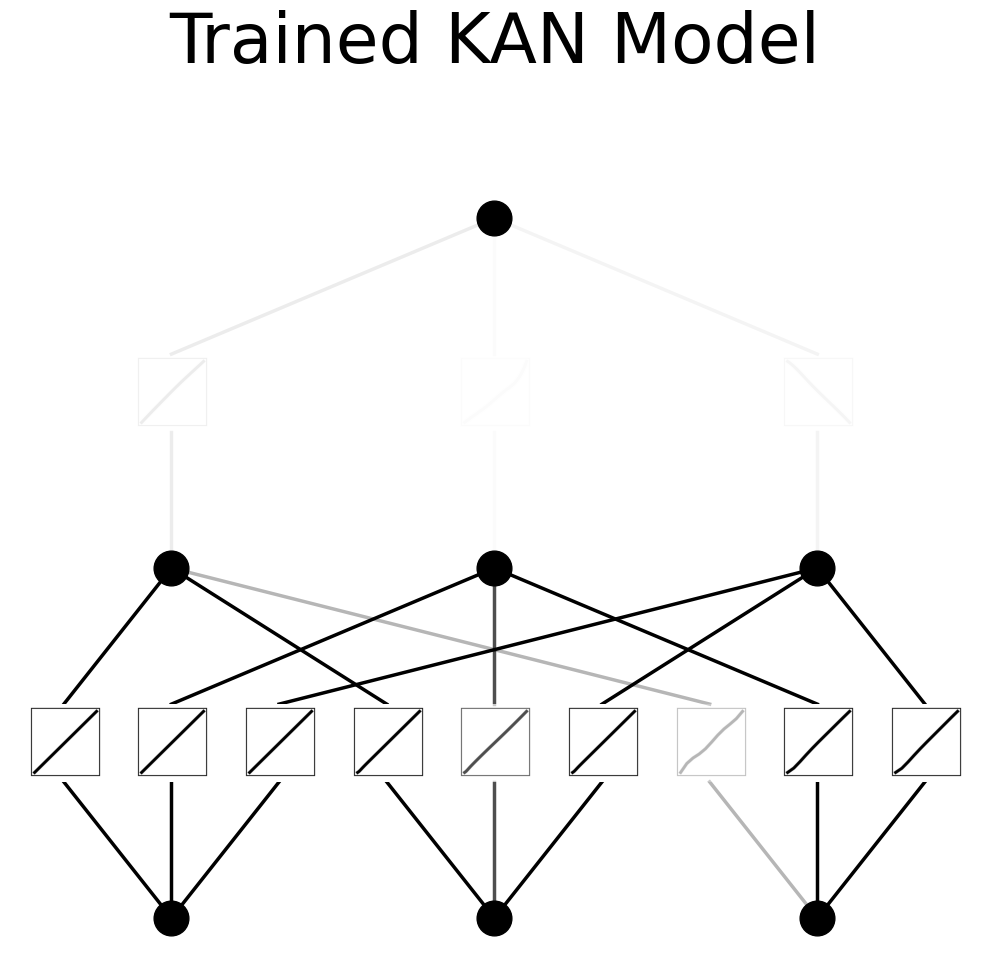

In [ ]:
# Plot the model after training
model.plot(beta=50, scale=1.25, title='Trained KAN Model')
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]

formula

In [ ]:
from kan import *
import matplotlib.pyplot as plt

# Assuming l, i, j are layer, input, and output indices respectively for the most significant node
l = 0  # Layer number
i = 3  # Input index
j = 1  # Output index

inputs = model.spline_preacts[l][:,j,i]
outputs = model.spline_postacts[l][:,j,i]
rank = np.argsort(inputs)  # Sort by inputs for a meaningful plot

# Plot activation functions
plt.figure(figsize=(8, 8))
plt.plot(inputs[rank], outputs[rank], marker="o", linestyle='-')
plt.title('Activation Function')
plt.xlabel('Inputs')
plt.ylabel('Outputs')
plt.grid(True)
plt.show()



IndexError: index 3 is out of bounds for dimension 2 with size 3

In [ ]:

import numpy as np
import sympy as sp

def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    # Convert your formula to a function that can accept NumPy arrays
    formula_func = sp.lambdify([sp.symbols(f'x_{i+1}') for i in range(X.shape[1])], formula, "numpy")
    for i in range(batch):
        prediction = formula_func(*X[i])  # Calculate the formula result
        # Assuming y[i] is binary and prediction needs to be rounded for comparison
        correct += (np.round(prediction) == y[i])
    return correct / batch

# Assuming you have converted your dataset's input data to NumPy arrays suitable for the formula function
print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))


train acc of the formula: tensor(0.4987)
test acc of the formula: tensor(0.9780)
